#  [Exploration] 😀MLOps 기초

---

CIFAR10 프로젝트를 기반으로 데이터를 수정하고 하이퍼파라미터 튜닝을 한 다음 배포해보자!

<br>  
<br>  
<br>

---

<br>  

## 🔶1. 모델 고정해서 사용하기  
이번 CIFAR10 프로젝트의 경우에는 모델을 고정해서 사용할 예정이다. 모델의 경우에는 다음과 같은 그림으로 구성  
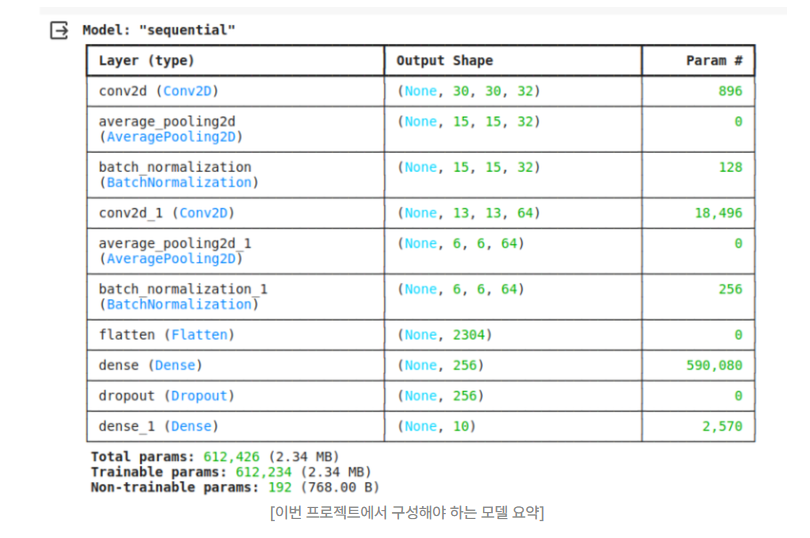

In [36]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# 데이터 로드
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# 데이터 전처리
train_images, test_images = train_images / 255.0, test_images / 255.0
train_labels, test_labels = to_categorical(train_labels), to_categorical(test_labels)

In [37]:
# 모델 구축
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.AveragePooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.AveragePooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(10, activation='softmax'))

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 요약
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
average_pooling2d_2 (Average (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
average_pooling2d_3 (Average (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)             

In [38]:
# 모델 학습
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

# 학습 과정 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))


Epoch 1/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.5194 - accuracy: 0.4907 - val_loss: 1.3462 - val_accuracy: 0.5329
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0657 - accuracy: 0.6257 - val_loss: 1.1077 - val_accuracy: 0.6153
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9140 - accuracy: 0.6797 - val_loss: 0.9901 - val_accuracy: 0.6580
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7942 - accuracy: 0.7218 - val_loss: 0.8933 - val_accuracy: 0.6950
Epoch 5/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.6899 - accuracy: 0.7579 - val_loss: 0.8828 - val_accuracy: 0.7029
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6131 - accuracy: 0.7831 - val_loss: 1.1073 - val_accuracy: 0.6642
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.5443 - accuracy: 0.8096 - val_loss: 1.0044 - val_accuracy:

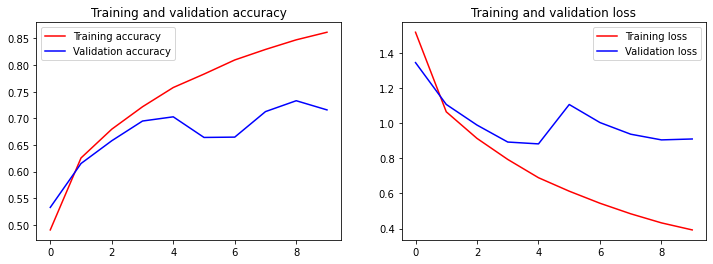

In [39]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 모델 저장
model.save("cifar10_justmodel.h5")

---

<br>  
<br>  
<br>  
<br>  

## 2. 🔶Data Centric AI 맛보기

---  

<br>  

Data Centric AI를 정석적으로 진행한다면 훈련 데이터셋과 테스트 데이터셋을 전부 열어서 확인해서 틀린 것이 없는지 검수해야 한다.  
하지만 우리에게는 일일이 해볼만한 시간은 존재하지 않으니 사람들이 미리 검수했던 내용들을 기반으로 프로젝트를 진행하겠다.  

<br>  

`labelerrors.com`은 **Data Centric AI**에서 가장 많이 활용하고 있는 파이썬 라이브러리인 cleanlab을 만든 개발자들이 공개한 사이트이다. `labelerrors.com`은 이름에서 알 수 있듯이 **테스트 데이터**와 label이 잘못 붙어 있는 사례를 모아 보여준다.
`labelerrors.com`에서 CIFAR10 테스트 데이터셋을 확인하고 아래 조그맣게 있는 ID를 기준으로 직접 데이터셋을 시각화하고 실제 label이 잘못 붙어있다면 label을 수정해보자.

In [64]:
import tensorflow as tf
from tensorflow.keras import datasets, models
import numpy as np
import matplotlib.pyplot as plt

# CIFAR-10 데이터셋 로드
(_, _), (test_images, test_labels) = datasets.cifar10.load_data()
test_images = test_images / 255.0  # 이미지 정규화

# 모델 로드
model = models.load_model("cifar10_justmodel.h5")

# CIFAR-10 클래스 목록
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 예측 수행
predictions = model.predict(test_images)

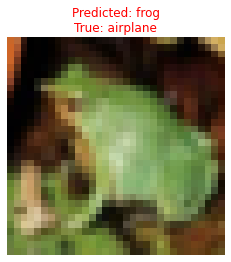

In [66]:
# 2405번째 이미지 예측 결과 출력
image_id = 2405
predicted_label = np.argmax(predictions[image_id])
true_label = np.argmax(test_labels[image_id])

# 이미지 시각화
plt.imshow(test_images[image_id])
plt.title(f'Predicted: {class_names[predicted_label]}\nTrue: {class_names[true_label]}', color='green' if predicted_label == true_label else 'red')
plt.axis('off')
plt.show()

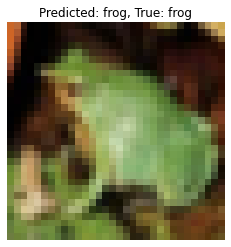

In [68]:
# 수정 전 이미지 ID에 대한 수정 후 라벨
modify_data = {
    6877: 8,  # "ship"의 클래스 ID는 8
    8058: 7,  # "horse"의 클래스 ID는 7
    2532: 1,  # "automobile"의 클래스 ID는 1
    7657: 7,  # "horse"의 클래스 ID는 7
    1969: 9,  # "truck"의 클래스 ID는 9
    2804: 5,  # "dog"의 클래스 ID는 5
    6792: 9,  # "truck"의 클래스 ID는 9
    1227: 5,  # "dog"의 클래스 ID는 5
    5191: 5,  # "dog"의 클래스 ID는 5
    5690: 4,  # "deer"의 클래스 ID는 4
    1718: 8,  # "ship"의 클래스 ID는 8
    2592: 4,  # "deer"의 클래스 ID는 4
    4794: 2,  # "bird"의 클래스 ID는 2
    5960: 3,  # "cat"의 클래스 ID는 3
    165: 2,   # "bird"의 클래스 ID는 2
    9227: 1,  # "automobile"의 클래스 ID는 1
    5632: 5,  # "dog"의 클래스 ID는 5
    9352: 9,  # "truck"의 클래스 ID는 9
    7846: 3,  # "cat"의 클래스 ID는 3
    6966: 8,  # "ship"의 클래스 ID는 8
    5468: 3   # "cat"의 클래스 ID는 3
}
# 수정 후의 예측 결과 출력
for image_id in modify_data.keys():
    predicted_label = np.argmax(predictions[image_id])
    true_label = test_labels[image_id, 0]

    # 이미지 시각화
    plt.imshow(test_images[image_id])
    plt.title(f'Predicted: {class_names[predicted_label]}, True: {class_names[true_label]}')
    plt.axis('off')
    plt.show()

- 일단 개구리 하나는 label 수정 완료!

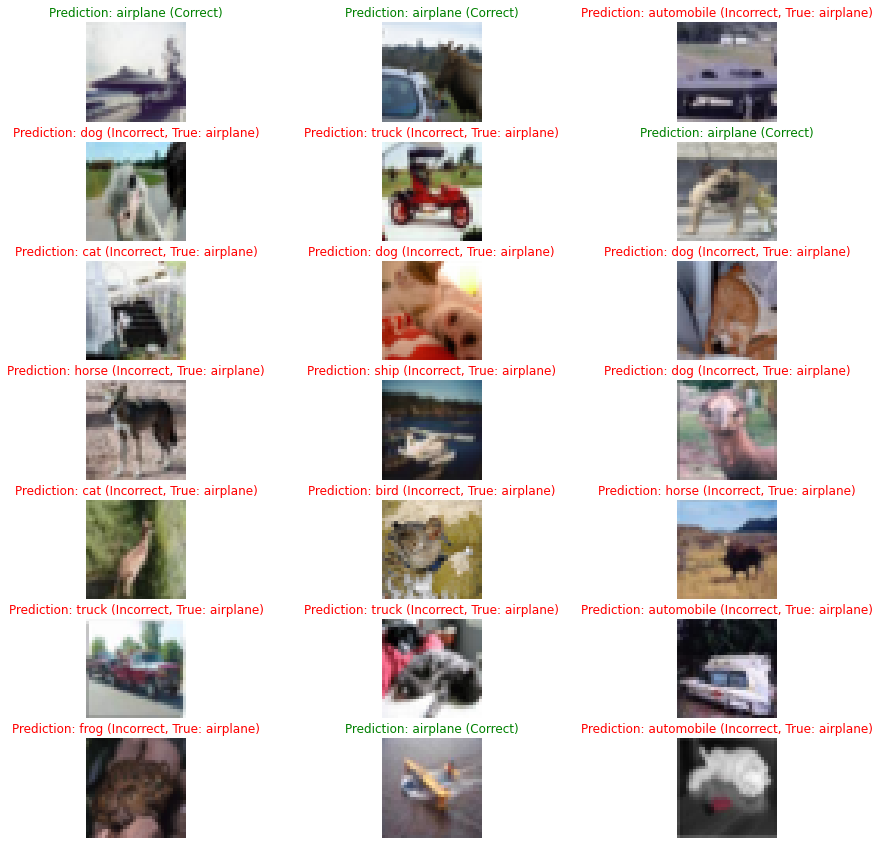

In [93]:
import numpy as np

# CIFAR-10 클래스 목록
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 선택한 이미지의 인덱스
indices_to_visualize = [6877, 8058, 2532, 7657, 1969, 2804, 6792, 1227, 5191, 5690, 1718, 2592, 4794, 5960, 165, 9227, 5632, 9352, 7846, 6966, 5468]

# 선택한 이미지와 라벨 추출
selected_images = test_images[indices_to_visualize]
true_labels = np.argmax(test_labels[indices_to_visualize], axis=1)

# 모델에서 예측한 라벨 가져오기
predicted_labels = np.argmax(model.predict(selected_images), axis=1)

# 이미지 및 예측/실제 라벨 시각화
num_images = len(indices_to_visualize)
rows = 7  
cols = 3

plt.figure(figsize=(15, 15))

for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    
    # 이미지 표시
    plt.imshow(selected_images[i])
    plt.axis('off')
    
    
    # 예측 및 실제 라벨 표시
    if predicted_labels[i] == true_labels[i]:
        plt.title(f'Prediction: {class_names[predicted_labels[i]]} (Correct)', color='green')
    else:
        plt.title(f'Prediction: {class_names[predicted_labels[i]]} (Incorrect, True: {class_names[true_labels[i]]})', color='red')

plt.show()

In [146]:
import tensorflow as tf
from tensorflow.keras import datasets, models
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

# CIFAR-10 데이터셋 로드
(_, _), (test_images, test_labels) = datasets.cifar10.load_data()
test_images = test_images / 255.0  # 이미지 정규화

# 모델 로드
model = models.load_model("cifar10_justmodel.h5")

# CIFAR-10 클래스 목록
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 수정할 이미지의 ID와 수정된 레이블
modify_data = {
    6877: 8,  # "ship"의 클래스 ID는 8
    8058: 7,  # "horse"의 클래스 ID는 7
    2532: 1,  # "automobile"의 클래스 ID는 1
    7657: 7,  # "horse"의 클래스 ID는 7
    1969: 9,  # "truck"의 클래스 ID는 9
    2804: 5,  # "dog"의 클래스 ID는 5
    6792: 9,  # "truck"의 클래스 ID는 9
    1227: 5,  # "dog"의 클래스 ID는 5
    5191: 5,  # "dog"의 클래스 ID는 5
    5690: 4,  # "deer"의 클래스 ID는 4
    1718: 8,  # "ship"의 클래스 ID는 8
    2592: 4,  # "deer"의 클래스 ID는 4
    4794: 2,  # "bird"의 클래스 ID는 2
    5960: 3,  # "cat"의 클래스 ID는 3
    165: 2,   # "bird"의 클래스 ID는 2
    9227: 1,  # "automobile"의 클래스 ID는 1
    5632: 5,  # "dog"의 클래스 ID는 5
    9352: 9,  # "truck"의 클래스 ID는 9
    7846: 3,  # "cat"의 클래스 ID는 3
    6966: 8,  # "ship"의 클래스 ID는 8
    5468: 3   # "cat"의 클래스 ID는 3
}

# # 수정된 레이블로 데이터 업데이트
# for img_id, new_label in modify_data.items():
#     test_labels[img_id] = to_categorical(new_label, num_classes=len(class_names))

# 수정된 레이블로 데이터 업데이트
for img_id, new_label in modify_data.items():
    # 해당 이미지에 대한 레이블 업데이트
    test_labels[img_id] = to_categorical(new_label, num_classes=len(class_names))[0]

#     # 해당 이미지에 대한 예측 수행
#     img = test_images[img_id].reshape(1, *test_images[img_id].shape)  # 모델의 입력 형태에 맞게 reshape
#     predicted_label = np.argmax(model.predict(img), axis=1)[0]

#     # 예측 결과 출력
#     print(f"Image ID: {img_id}, Predicted Label: {class_names[predicted_label]}, True Label: {class_names[new_label]}")

In [147]:
# # 이미지 및 예측/실제 라벨 시각화 (업데이트된 라벨 기준)
# plt.figure(figsize=(15, 15))

# for i in range(num_images):
#     plt.subplot(rows, cols, i + 1)
    
#     # 이미지 표시
#     plt.imshow(selected_images[i])
#     plt.axis('off')
    
#     # 업데이트된 라벨 표시
#     updated_label = np.argmax(test_labels[indices_to_visualize[i]])
    
#     # 예측 및 실제 라벨 표시
#     if predicted_labels[i] == updated_label:
#         plt.title(f'Prediction: {class_names[predicted_labels[i]]} (Correct)', color='green')
#     else:
#         plt.title(f'Prediction: {class_names[predicted_labels[i]]} (Incorrect, Updated: {class_names[updated_label]})', color='red')

# plt.show()



- 브로드캐스팅 문제는 해결됐는데 데이터 업데이트가 안됐다.

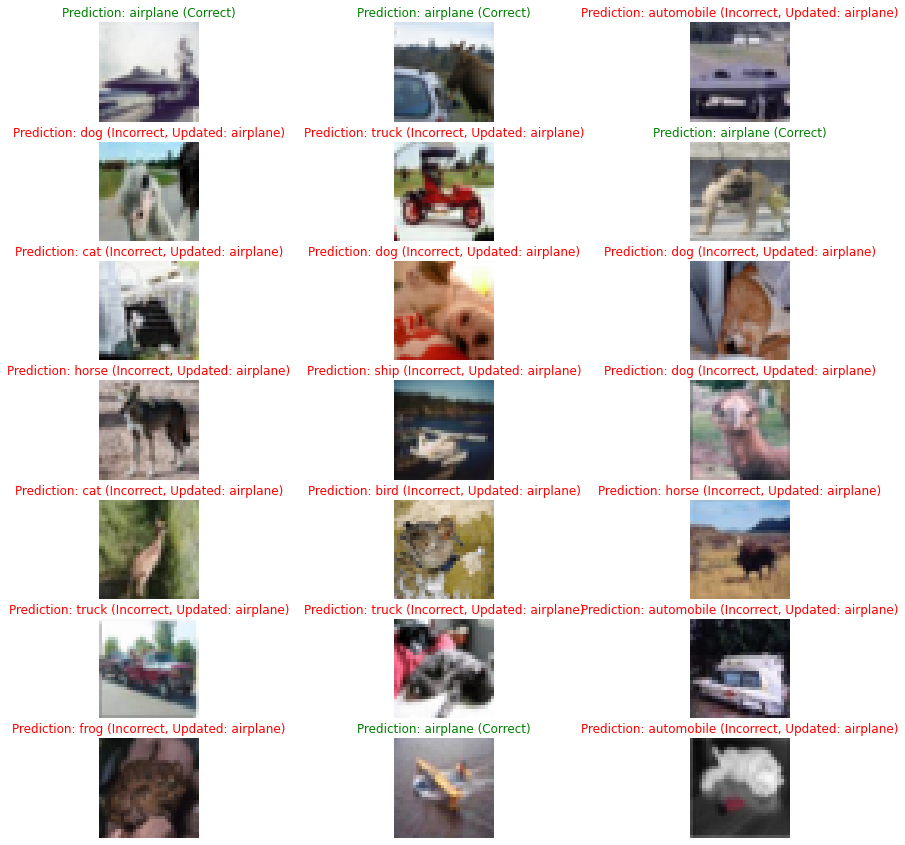

In [148]:
# 새로운 레이블 배열 생성
updated_labels = np.copy(test_labels)

# 수정된 레이블로 데이터 업데이트
for img_id, new_label in modify_data.items():
    # 해당 이미지에 대한 레이블 업데이트
    updated_labels[img_id] = to_categorical(new_label, num_classes=len(class_names))[0]

# 이미지 및 예측/실제 라벨 시각화 (업데이트된 라벨 기준)
plt.figure(figsize=(15, 15))

for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    
    # 이미지 표시
    plt.imshow(selected_images[i])
    plt.axis('off')
    
    # 업데이트된 라벨 표시
    updated_label = np.argmax(updated_labels[indices_to_visualize[i]])
    
    # 예측 및 실제 라벨 표시
    if predicted_labels[i] == updated_label:
        plt.title(f'Prediction: {class_names[predicted_labels[i]]} (Correct)', color='green')
    else:
        plt.title(f'Prediction: {class_names[predicted_labels[i]]} (Incorrect, Updated: {class_names[updated_label]})', color='red')

# 새로운 레이블 배열을 test_labels에 할당
test_labels = updated_labels

plt.show()


- 마찬가지로 업데이트가 안되고 있다..😓

In [134]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
average_pooling2d_2 (Average (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
average_pooling2d_3 (Average (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)             

In [133]:
# 모델 로드
model = models.load_model("cifar10_justmodel.h5")

# 모델 평가
model.evaluate(test_images, test_labels)

ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1330 test_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1320 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1313 run_step  **
        outputs = model.test_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1269 test_step
        self.compiled_loss(
    /opt/conda/lib/python3.9/site-packages/keras/engine/compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /opt/conda/lib/python3.9/site-packages/keras/losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    /opt/conda/lib/python3.9/site-packages/keras/losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/losses.py:1665 categorical_crossentropy
        return backend.categorical_crossentropy(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/backend.py:4839 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 10) are incompatible


- 마지막 Dense레이어도   (None, 10)  로 나오고 있는데 잘 안되고 있다..

In [138]:
# 수정된 레이블로 데이터 업데이트
for img_id, new_label in modify_data.items():
    # 해당 이미지에 대한 레이블 업데이트
    test_labels[img_id] = to_categorical(new_label, num_classes=len(class_names))[0]

# # 해당 이미지에 대한 예측 수행 및 결과 출력 (옵션)
# for img_id, new_label in modify_data.items():
#     # 해당 이미지에 대한 예측 수행
#     img = test_images[img_id].reshape(1, *test_images[img_id].shape)  # 모델의 입력 형태에 맞게 reshape
#     predicted_label = np.argmax(model.predict(img), axis=1)[0]

#     # 예측 결과 출력
#     print(f"Image ID: {img_id}, Predicted Label: {class_names[predicted_label]}, True Label: {class_names[new_label]}")


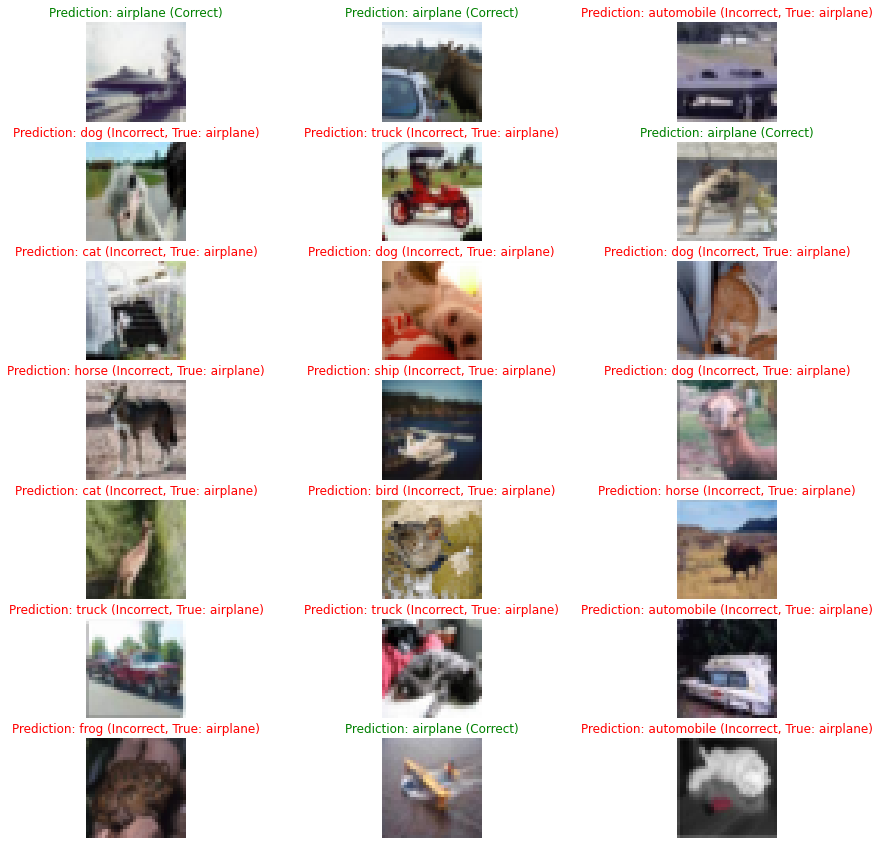

In [130]:
# 선택한 이미지의 인덱스
indices_to_visualize = list(modify_data.keys())

# 선택한 이미지와 라벨 추출
selected_images = test_images[indices_to_visualize]
true_labels = np.argmax(test_labels[indices_to_visualize], axis=1)

# 모델에서 예측한 라벨 가져오기
predicted_labels = np.argmax(model.predict(selected_images), axis=1)

# 이미지 및 예측/실제 라벨 시각화
num_images = len(indices_to_visualize)
rows = 7  
cols = 3

plt.figure(figsize=(15, 15))

for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    
    # 이미지 표시
    plt.imshow(selected_images[i])
    plt.axis('off')
    
    # 예측 및 실제 라벨 표시
    if predicted_labels[i] == true_labels[i]:
        plt.title(f'Prediction: {class_names[predicted_labels[i]]} (Correct)', color='green')
    else:
        plt.title(f'Prediction: {class_names[predicted_labels[i]]} (Incorrect, True: {class_names[true_labels[i]]})', color='red')

plt.show()


---

<br>  
<br>  
<br>  
<br>  

## ⛓️회고
<br>  

- **Keep**  
    구글링을 열심히 했다.  
    
<br>  

- **Problem**  
    하나만 했을 땐 잘 되었던 것이 나머지 21개의 잘못된 라벨을 수정하고 업데이트하는 부분에서 막혀서 뭐가 문제인지 알 수가 없었다.. 하이퍼파라미터 튜닝까지 할 시간이 없었다. 시간계산을 잘 했으면 이런 저런 시도를 해볼 수 있었을 텐데 아쉽다.  
    
    <br>  
    
- **Try**  
    포기하지않았다.